In [183]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
import sys
import logging
from glob import glob
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

logging.basicConfig(level=logging.INFO)
sys.path.append('..')
from src.models import get_model, SteganographyModels
from src.__main__ import CLI
from src.config import TMP_FOLDER

print("Available models:")
print('\n'.join(list(map(lambda x: str(x).split('.')[-1], SteganographyModels))))

Available models:
LSB
BASE_MERGE
WT
DCT


## Constants

In [185]:
IMAGE_PATH = "../tests/test_images/cat.jpg"
#IMAGE_PATH = "../tests/test_messages/cs.png"

MODEL_NAME = "DCT"

#MESSAGE = "Hello world !" * 100
MESSAGE = "../tests/test_images/casoar.jpeg"
MESSAGE = "../tests/test_messages/noisette.jpg"

## Show image and hide the image

In [186]:
cli = CLI()

INFO:CLI:Starting your request !


INFO:CLI:Loading image.


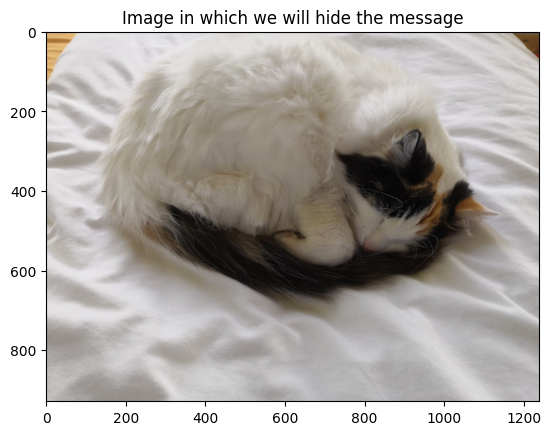

In [187]:
image = cli._load_image(IMAGE_PATH)
plt.figure()
plt.title("Image in which we will hide the message")
plt.imshow(image)
plt.show()

INFO:CLI:Loading message to hide.


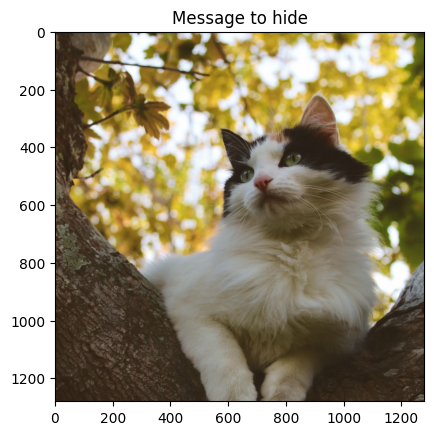

In [188]:
message = cli._load_message(MESSAGE)

if isinstance(message, str):
    print(message[:300])
else:
    plt.figure()
    plt.title("Message to hide")
    plt.imshow(message)
    plt.show()

In [189]:
model = get_model(MODEL_NAME)

In [190]:
encoded_image = model.encode(
    image=image, message=message
)
print(encoded_image.shape)

(929, 929, 3)


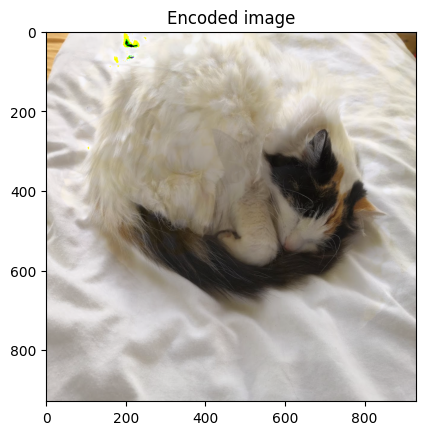

In [220]:
plt.figure()
plt.imshow(encoded_image)
plt.title("Encoded image")
plt.show()

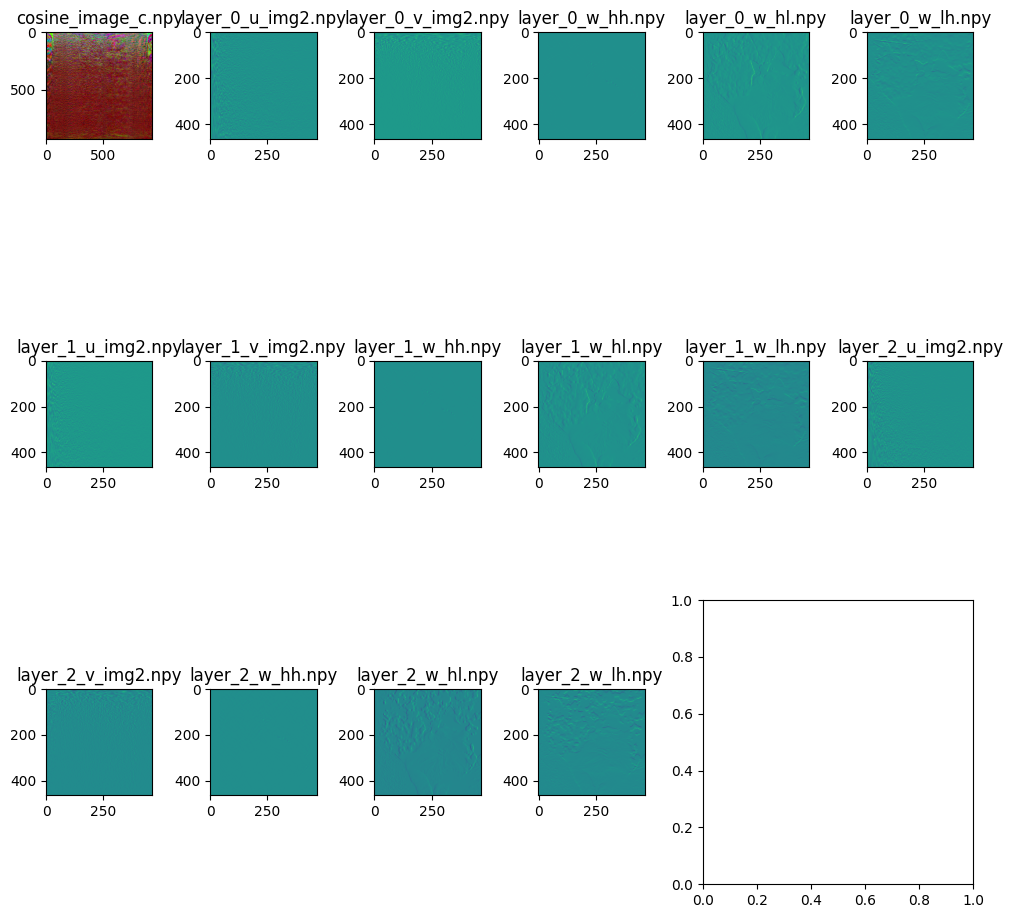

In [213]:
# Display the other images (in the tmp folder)
matrices_paths = list(glob(os.path.join(TMP_FOLDER, "*.npy")))
matrices = list(map(lambda x: (x, np.load(x, allow_pickle=True)), matrices_paths))
matrices = list(filter(lambda x: x[1].ndim >=2, matrices))

nbr_per_line = 3
names = list(map(lambda x: x[0], matrices))
names += [None for _ in range(nbr_per_line - len(names) % nbr_per_line)]
# convert names to a 2D of size 3
names = np.array(names).reshape(nbr_per_line, -1)
fig, axd = plt.subplot_mosaic(names, figsize=(10, 10))
plt.tight_layout()

for matrix_path, matrix in matrices:
    ax = axd[matrix_path]
    ax.imshow(matrix)
    ax.set_title(os.path.basename(matrix_path))


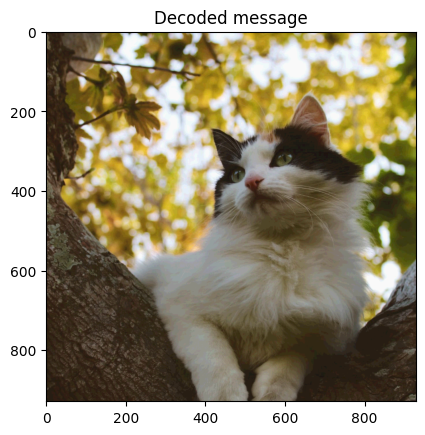

In [214]:
message = model.decode(encoded_image)
if isinstance(message, str):
    print('Decoded message:')
    print(message[:40])
    assert message == MESSAGE, "The messages are not the same"
else:
    plt.figure()
    plt.title("Decoded message")
    plt.imshow(message)
    plt.show()

## Data analysis

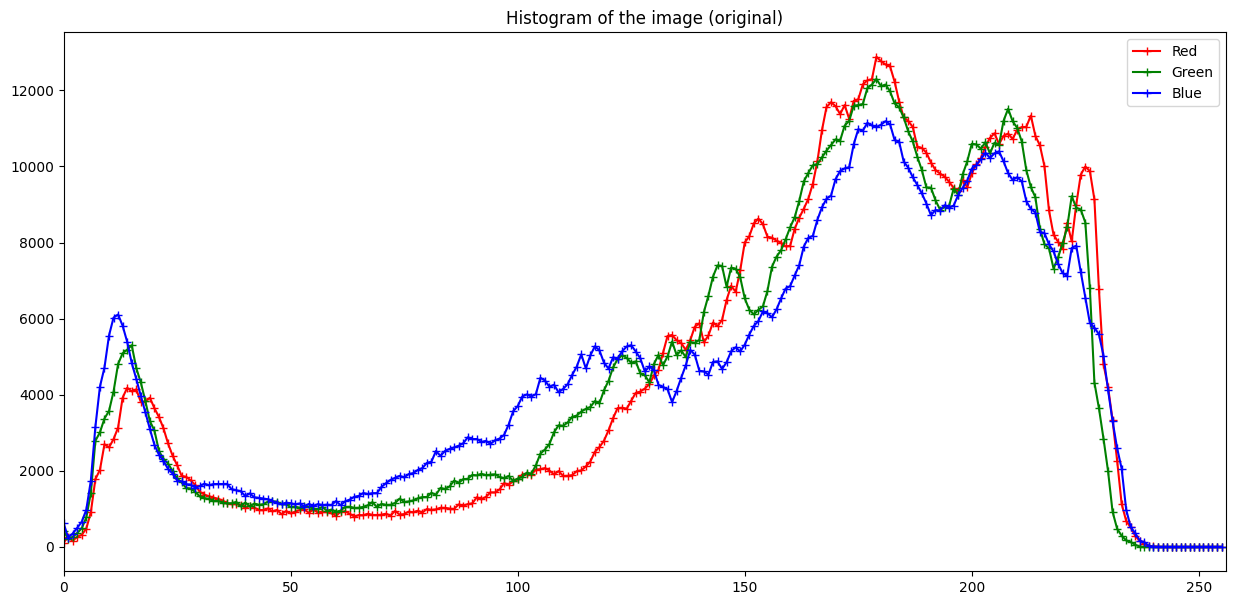

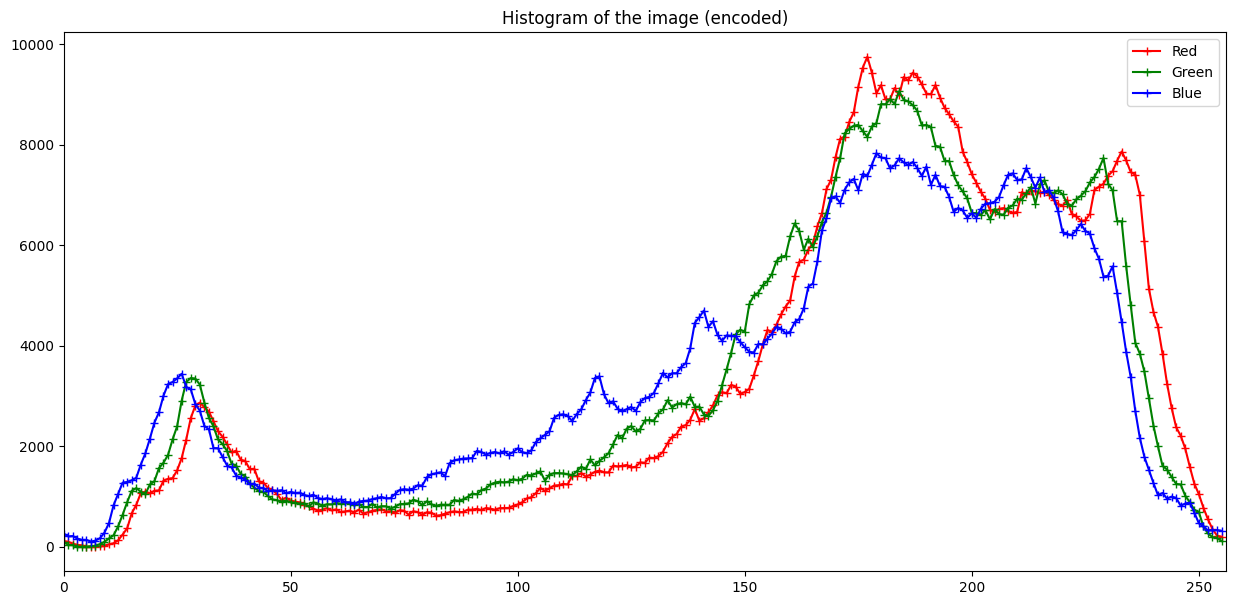

In [215]:
from src.analysis.histogram import generate_histogram, plot_histogram, compare_histograms, compute_diff_imgs

plt.figure(figsize=(15,7))
plt.title('Histogram of the image (original)')
plot_histogram(generate_histogram(image))
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (encoded)')
plot_histogram(generate_histogram(encoded_image))

        score     image channel
0   73.282341   Encoded       R
1   74.188217   Encoded       G
2   75.685974   Encoded       B
0  116.351517  Original       R
1  117.069374  Original       G
2  111.428413  Original       B


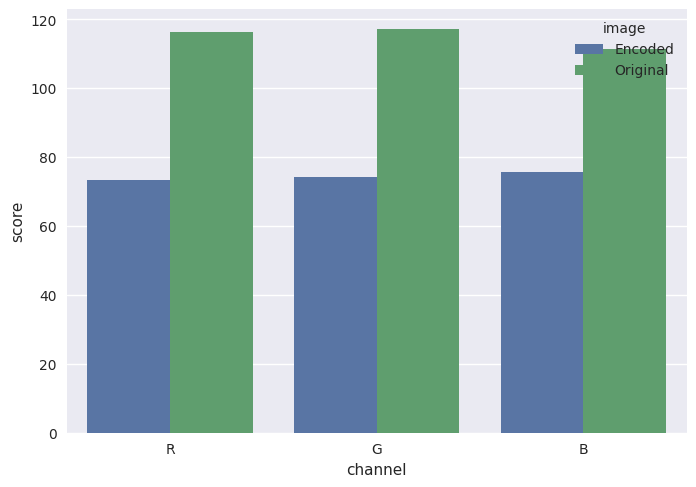

In [216]:
from src.analysis.histogram import histogram_anomaly_score

hist = generate_histogram(image)
anomaly_scores_original = histogram_anomaly_score(hist)

hist = generate_histogram(encoded_image)
anomaly_scores_encoded = histogram_anomaly_score(hist)

df = pd.concat([
    pd.DataFrame({
        "score": score,
        "image": image_name,
        "channel": list("RGB")
    })
    for score, image_name in zip([anomaly_scores_encoded, anomaly_scores_original], ['Encoded', 'Original'])
])
print(df.head(6))
plt.style.use('seaborn')
sns.barplot(data=df, x="channel", y="score", hue="image")
plt.style.use("default")
plt.show()

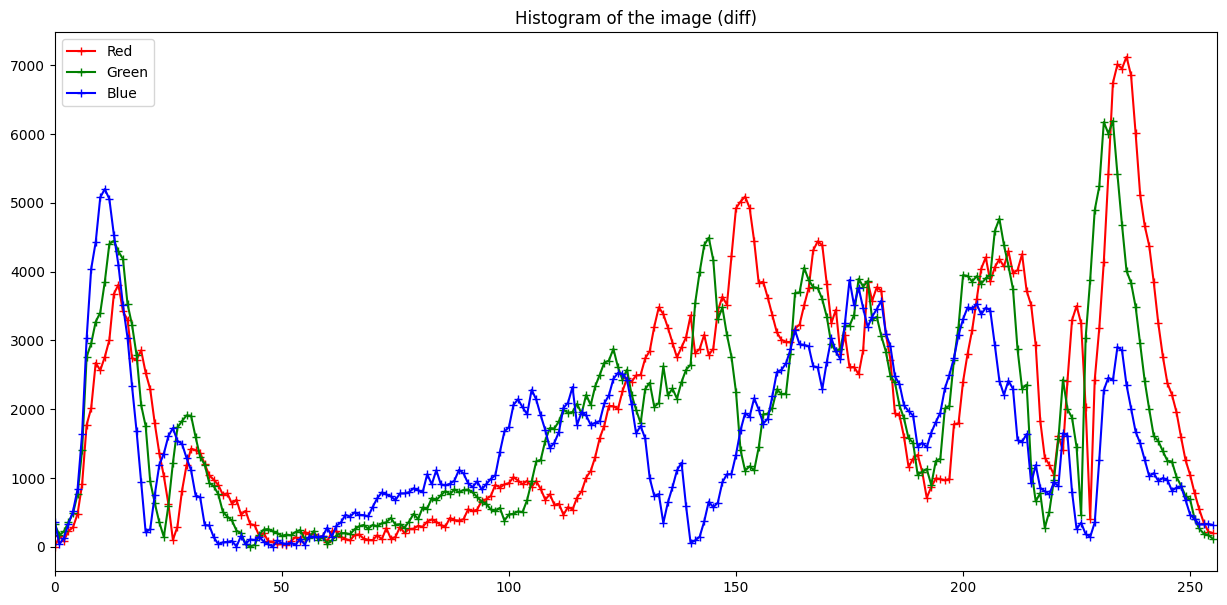

In [217]:
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (diff)')

plot_histogram(
    compare_histograms(
        generate_histogram(image),
        generate_histogram(encoded_image)
    )
)

(929, 1239, 3) (929, 929, 3)


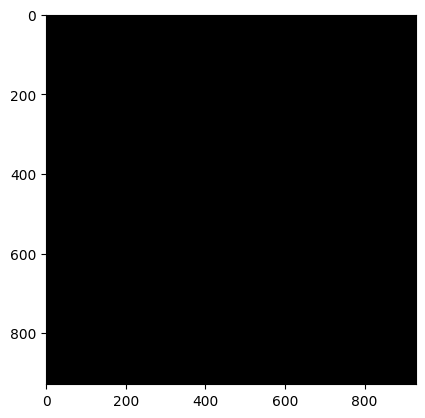

In [218]:
print(image.shape, encoded_image.shape)
image_ = cv2.resize(image, (encoded_image.shape[1], encoded_image.shape[0]))
plt.imshow(compute_diff_imgs(image_, encoded_image), cmap='gray');

d:\Documents\stenography\notebooks\..\src\analysis\least_significant_bit.py:37: UserWarning: Possible precision loss converting image of type int32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return entropy(image, disk(disk_size))
d:\Documents\stenography\venv\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


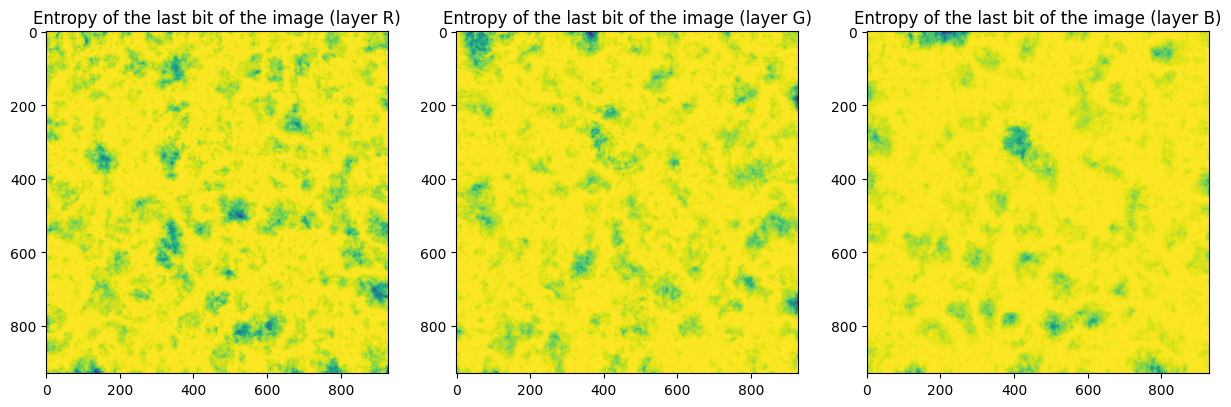

In [219]:
from src.analysis.least_significant_bit import least_significant_bit_image, generate_entropy_image

# Check entropy of the last bit of the image
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, layer_id in zip(axes, range(3)):
    ax.set_title(f'Entropy of the last bit of the image (layer {"RGB"[layer_id]})')
    entropy_image = generate_entropy_image(
        least_significant_bit_image(encoded_image[:,:,layer_id]),
        40
    )
    ax.imshow(entropy_image)